In [4]:
import geopandas as gpd
import xarray as xr
import pandas as pd
from operator import itemgetter
import numpy as np
import scipy.stats as stats
import rioxarray as rioxr
from rasterio.enums import Resampling


import datetime as dt
import matplotlib.pyplot as plt
import shapely
import contextily as cx
import seaborn as sns 
from dataretrieval import nwis



In [5]:
column_dict = {'09034900': 'BOBTAIL CREEK NEAR JONES PASS, CO.',
                '09035900': 'SOUTH FORK OF WILLIAMS FORK NEAR LEAL, CO.',
                '09035800': 'DARLING CREEK NEAR LEAL, CO.',
                '09047700': 'KEYSTONE GULCH NEAR DILLON, CO.',
                '09066000': 'BLACK GORE CREEK NEAR MINTURN, CO.',
                '09065500': 'GORE CREEK AT UPPER STATION, NEAR MINTURN, CO.',
                '09066200': 'BOOTH CREEK NEAR MINTURN, CO.',
                '09066300': 'MIDDLE CREEK NEAR MINTURN, CO.',
                '09081600': 'CRYSTAL RIVER AB AVALANCHE C, NEAR REDSTONE, CO.',
                '09107000': 'TAYLOR RIVER AT TAYLOR PARK, CO.',
                '09110000': 'TAYLOR RIVER AT ALMONT, CO.',
                '09112500': 'EAST RIVER AT ALMONT CO.',
                '09115500': 'TOMICHI CREEK AT SARGENTS, CO.',
                '09119000': 'TOMICHI CREEK AT GUNNISON, CO.',
                '09124500': 'LAKE FORK AT GATEVIEW, CO.',
                '09125000': 'CURECANTI CREEK NEAR SAPINERO, CO.',
                '09128500': 'SMITH FORK NEAR CRAWFORD, CO.',
                '09132500': 'NORTH FORK GUNNISON RIVER NEAR SOMERSET, CO.',
                '09146200': 'UNCOMPAHGRE RIVER NEAR RIDGWAY, CO.',
                '09147500': 'UNCOMPAHGRE RIVER AT COLONA, CO.',
                '09165000': 'DOLORES RIVER BELOW RICO, CO.',
                '09168100': 'DISAPPOINTMENT CREEK NEAR DOVE CREEK, CO.',
                '09239500': 'YAMPA RIVER AT STEAMBOAT SPRINGS, CO.',
                '09241000': 'ELK RIVER AT CLARK, CO.',
                '09245000': 'ELKHEAD CREEK NEAR ELKHEAD, CO.',
                '09250000': 'MILK CREEK NEAR THORNBURGH, CO.',
                '09304500': 'WHITE RIVER NEAR MEEKER, CO.',
                '09352900': 'VALLECITO CREEK NEAR BAYFIELD, CO.',
                '09361500': 'ANIMAS RIVER AT DURANGO, CO.'}

In [6]:
# Get UCRB stations
ucrb_hcdn_stations = gpd.read_file('./ucrb_hcdn_co_gdf_final.json')

# Add 0 to the station  ID
ucrb_hcdn_stations['STAID'] = ['0'+str(id) for id in ucrb_hcdn_stations['STAID']]
ucrb_hcdn_stations = ucrb_hcdn_stations[~ucrb_hcdn_stations['STAID'].isin(['09168100','09250000'])]

# Get basin polygons
basins = gpd.read_file(r"C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\sublimation_of_snow\data\bas_nonref_WestMnts.shp")

# Create new crs and drop one of the columns
ucrb_hcdn_co_gdf = ucrb_hcdn_stations.to_crs(basins.crs)
ucrb_hcdn_co_gdf = ucrb_hcdn_co_gdf.drop('index_right',axis=1)

# Combine to find locations of sites within basins
ucrb_hcdn_combined = gpd.sjoin(basins,ucrb_hcdn_co_gdf)

In [7]:
# Get the smallest basin that matches each gage location
idx = []
for station in ucrb_hcdn_combined['STANAME'].unique():
    tmp = ucrb_hcdn_combined[ucrb_hcdn_combined['STANAME']==station]
    idx.append(tmp.loc[tmp['AREA'].idxmin()])
ucrb_hcdn_basins = gpd.GeoDataFrame(idx, crs=basins.crs)
# Change the crs
ucrb_hcdn_basins = ucrb_hcdn_basins.to_crs(epsg='4326')


In [8]:
idx_gages = []
for gage in ucrb_hcdn_basins.GAGE_ID:
    tmp = ucrb_hcdn_basins[ucrb_hcdn_basins.GAGE_ID == gage]
    if tmp['DRAIN_SQKM'].idxmax() not in idx_gages:
        idx_gages.append(tmp['DRAIN_SQKM'].idxmax())

In [9]:
ucrb_hcdn_basins_filtered = ucrb_hcdn_basins.loc[idx_gages].reset_index()
# ucrb_hcdn_basins_filtered.to_file('./ucrb_hcdn_co_polygons_final.json')

In [11]:
# ucrb_hcdn_stations = gpd.read_file('./ucrb_hcdn_co_gdf_final.json')
# ucrb_hcdn_stations['geometry'] = gpd.GeoSeries(ucrb_hcdn_stations['geometry']).map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))
# ucrb_hcdn_stations = ucrb_hcdn_stations.set_crs(epsg='4326')

station_ids = list(column_dict.keys())

hcdn_streamflow_df = nwis.get_dv(sites=station_ids, start='1950-10-01', end='2021-09-30')


In [12]:
df = hcdn_streamflow_df[0]['00060_Mean'].reset_index()

df['datetime']=[d.date() for d in df['datetime']]
df['datetime']= pd.to_datetime(df['datetime'])
df = df.set_index(['site_no','datetime'])
hcdn_q_ds = df.to_xarray()

In [13]:
hcdn_q_spring_summer_ds = hcdn_q_ds.where(hcdn_q_ds.datetime.dt.month.isin([4,5,6,7,8,9])).to_dataframe().dropna().to_xarray()
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_ds.groupby('datetime.year').mean()

In [50]:
# Function to get the day of Water Year
def date2DOWY(day_of_interest):
    day_of_interest = pd.to_datetime(day_of_interest)
    if day_of_interest >= dt.datetime(day_of_interest.year,10,1):
        dowy_start = dt.datetime(day_of_interest.year,10,1)
    else: 
        dowy_start = dt.datetime(day_of_interest.year-1,10,1)
    dowy = day_of_interest - dowy_start
    return dowy.days



In [121]:
northern_names = ['09034900', '09035900',  '09047700', '09066000',
       '09065500', '09066200', '09066300', '09239500', 
        '09304500'] # removed '09035800','09241000'
central_names = ['09081600',  '09112500',  '09132500'] # removed '09115500','09125000', '09128500','09110000','09107000',
southern_names = ['09119000', '09124500', '09146200', '09147500', '09165000',
       '09352900', '09361500']

In [51]:
# fig, axs = plt.subplots(nrows=len(northern_names))
df = hcdn_q_ds.to_dataframe().reset_index().set_index('datetime')
df_list= [df[df['site_no']==site].rename(columns={'00060_Mean':site})[site] for site in df['site_no'].unique()]
streamflow_df = pd.concat(df_list, axis=1)
# add dowy to data 
# Create an empty array with the same length as the day of water year
dowy = np.zeros(len(streamflow_df.index))
for i,date in enumerate(streamflow_df.index):
    dowy[i] = date2DOWY(date)
streamflow_df['dowy']=dowy

In [86]:
import datetime as dt

In [143]:
area_dict = {'09034900': 42824700.0,
            '09035900': 231888000.0,
            '09035800': 231888000.0,
            '09047700': 851630000.0,
            '09066000': 199226000.0,
            '09065500': 199226000.0,
            '09066200': 199226000.0,
            '09066300': 199226000.0,
            '09081600': 904256000.0,
            '09107000': 659841000.0,
            '09110000': 1237290000.0,
            '09112500': 748983000.0,
            '09115500': 384949000.0,
            '09119000': 2743500000.0,
            '09124500': 879200000.0,
            '09125000': 90731700.0,
            '09128500': 111863000.0,
            '09132500': 1362950000.0,
            '09146200': 384269000.0,
            '09147500': 1159220000.0,
            '09165000': 1306860000.0,
            '09239500': 1460040000.0,
            '09241000': 560678000.0,
            '09245000': 444132000.0,
            '09304500': 1939880000.0,
            '09352900': 656343000.0,
            '09361500': 2005600000.0}

<Axes: xlabel='datetime', ylabel='09112500'>

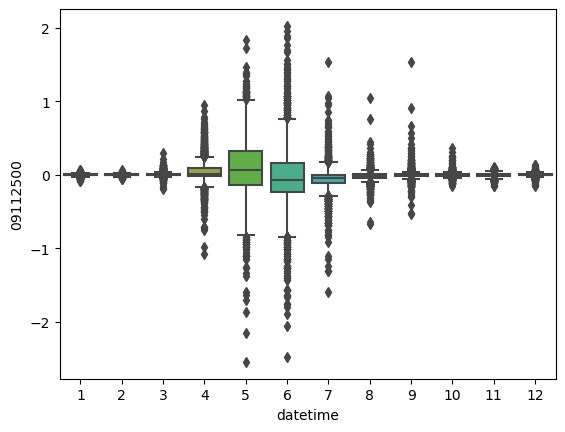

In [166]:

streamflow_df_mm = pd.DataFrame(((streamflow_df['09112500']/35.315)/area_dict['09112500']) * 1000 * 3600 * 24).diff()
sns.boxplot(x=streamflow_df_mm.index.month,
            y=streamflow_df_mm['09112500'])

In [174]:
streamflow_df['WY'] = streamflow_df.index.year.where(streamflow_df.index.month<10, streamflow_df.index.year+1)

In [181]:
import statsmodels.api as sm

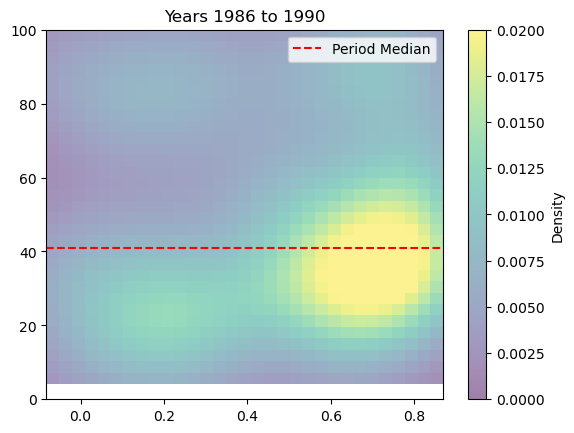

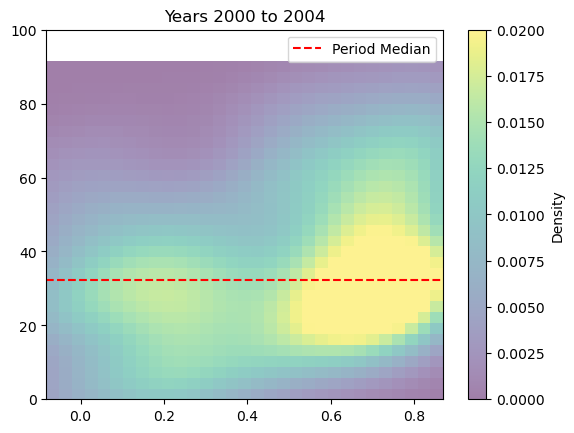

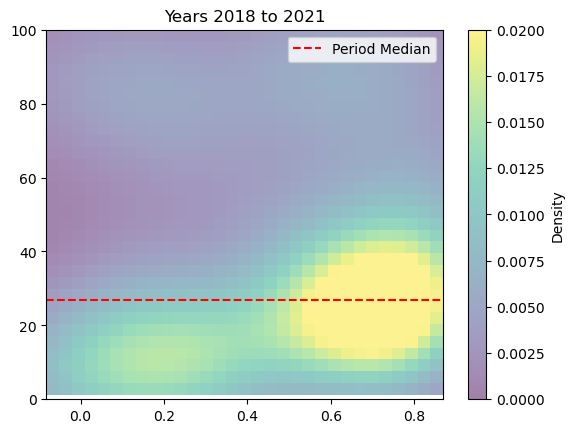

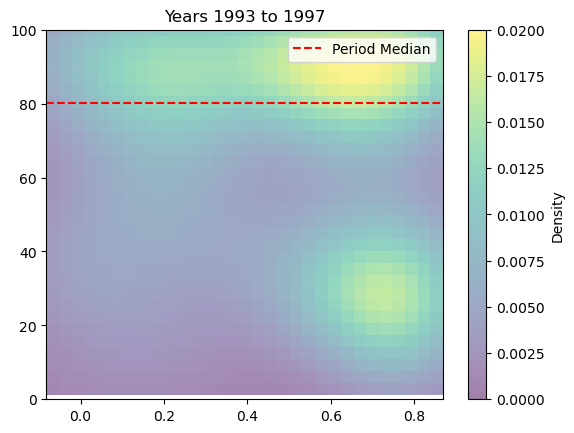

In [364]:
flow_sums_hcdn = streamflow_df.groupby('WY').sum().drop('dowy', axis=1)
from scipy.stats import gaussian_kde
dry0 = [1986,1987,1988,1989,1990]
dry1 = [2000,2001,2002,2003,2004]
# dry2 = [2012]
dry3 = [2018,2019,2020,2021]
wet1 = [1993,1994,1995,1996,1997]
for period in [dry0,dry1,dry3,wet1]:
    fig, ax = plt.subplots()
    for i,y in enumerate(period):
        year=y
        lag_1_autocorr = {}
        flow_percentile = {}
        for site in flow_sums_hcdn.columns:
            lag_1_autocorr[site] = sm.tsa.acf(flow_sums_hcdn[site])[1]
            flow_percentile[site] = (flow_sums_hcdn[site].rank(pct=True)*100).loc[year]
        if i == 0:
            lag_1_df = pd.DataFrame(pd.Series(lag_1_autocorr))
            lag_1_df = lag_1_df.rename(columns={0:f'lag_1_{year}'})
            flow_percentile_df = pd.DataFrame(pd.Series(flow_percentile))
            flow_percentile_df = flow_percentile_df.rename(columns={0:f'flow_percentile_{year}'})
        else:
            lag_1_df[f'lag_1_{year}'] = lag_1_autocorr.values()
            flow_percentile_df[f'flow_percentile_{year}'] = flow_percentile.values()
    x = np.nan_to_num(lag_1_df.values.flatten())
    y = np.nan_to_num(flow_percentile_df.values.flatten())



    k = gaussian_kde(np.vstack([x, y]))
    xi, yi = np.mgrid[x.min():x.max():1000**0.5*1j,y.min():y.max():1000**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    ax.set_ylim(0,100)
    h = ax.pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=0.5, vmin=0, vmax=0.02)
    ax.axhline(np.median(y),color='r',ls='--', label='Period Median')
    ax.legend()
    ax.set_title(f'Years {period[0]} to {period[-1]}')
    plt.colorbar(h, label='Density')
   

51.40845070422535

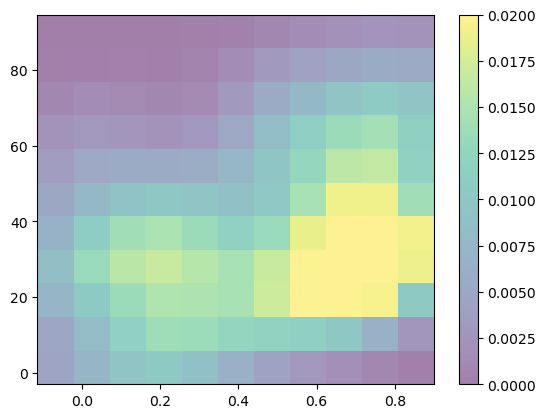

Text(0.02, 0.5, 'Discharge (m$^3$/s)')

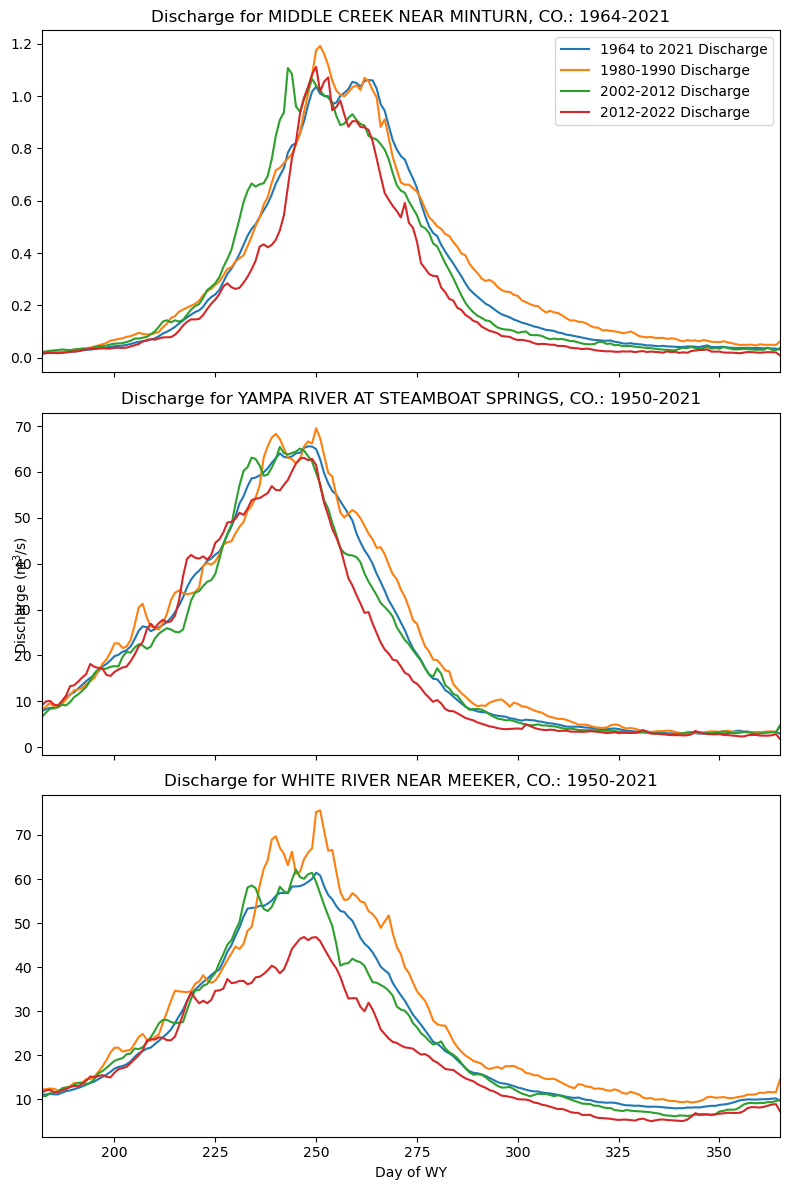

In [123]:
fig, axs = plt.subplots(nrows=len(northern_names[-3:]), figsize=(8,12), tight_layout=True, sharex=True)
for i,site in enumerate(northern_names[-3:]):
    ax=axs[i]
    min_year = streamflow_df[site].dropna().index.year.min()
    max_year = streamflow_df[site].dropna().index.year.max()
    (streamflow_df[[site,'dowy']].groupby('dowy').mean()*0.0283).plot(ax=ax, label=f'{min_year} to {max_year} Discharge',legend=False)
    (streamflow_df[[site,'dowy']].loc[dt.date(1980,10,1):dt.date(1990,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='1983-1987 Discharge',legend=False)
    (streamflow_df[[site,'dowy']].loc[dt.date(2000,10,1):dt.date(2011,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='2000-2004 Discharge',legend=False)
    # (streamflow_df[[site,'dowy']].loc[dt.date(2011,10,1):dt.date(2015,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='2012-2015 Discharge',legend=False)
    (streamflow_df[[site,'dowy']].loc[dt.date(2011,10,1):dt.date(2022,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='2018-2022 Discharge',legend=False)
    ax.set_title
    if i == 0:
        ax.legend([f'{min_year} to {max_year} Discharge',
                    '1980-1990 Discharge',
                    '2002-2012 Discharge',
                    '2012-2022 Discharge'])
    ax.set_title(f'Discharge for {column_dict[site]}: {min_year}-{max_year}')
    # ax.set_ylabel('Discharge (cfs)')
    ax.set_xlabel('Day of WY')
    ax.set_xlim(182,365)
fig.text(0.02, 0.5, 'Discharge (m$^3$/s)', va='center', rotation='vertical')

Text(-0.02, 0.5, 'Discharge (m$^3$/s)')

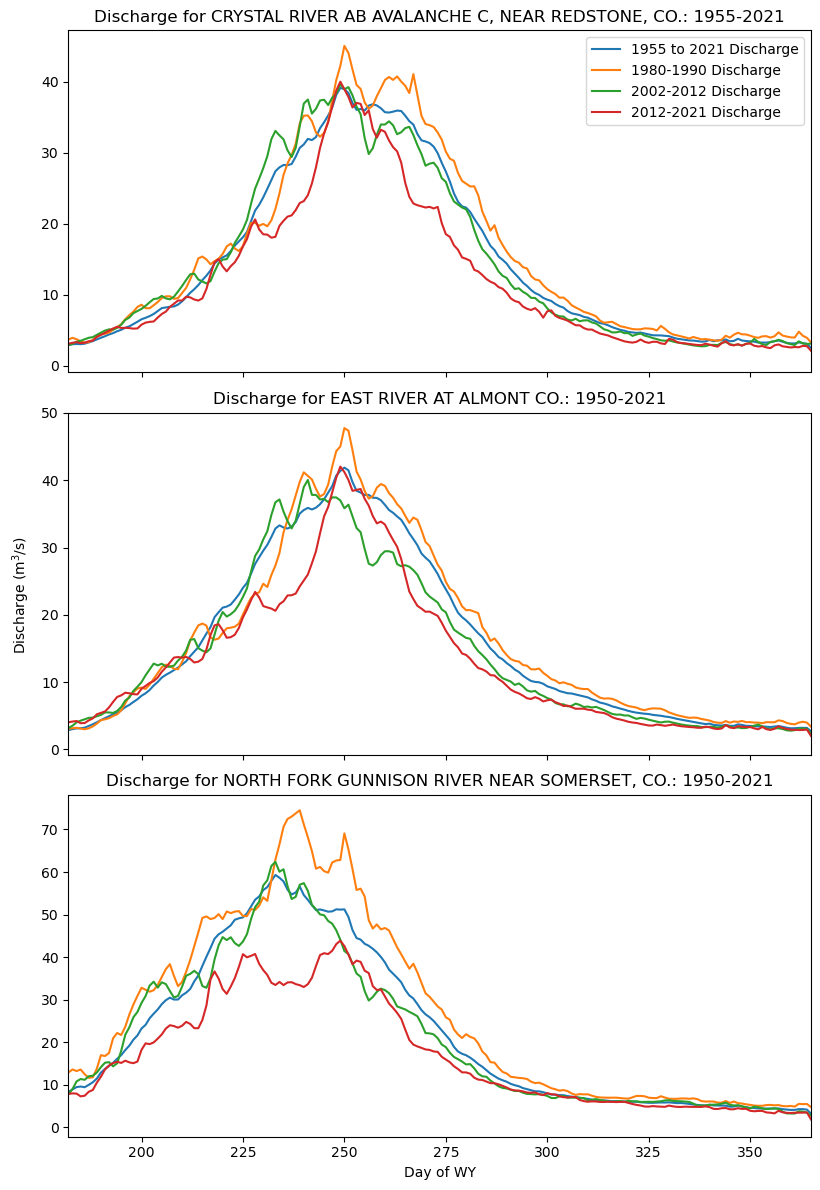

In [122]:
fig, axs = plt.subplots(nrows=len(central_names), figsize=(8,12), tight_layout=True, sharex=True)
for i,site in enumerate(central_names):
    ax=axs[i]
    min_year = streamflow_df[site].dropna().index.year.min()
    max_year = streamflow_df[site].dropna().index.year.max()
    (streamflow_df[[site,'dowy']].groupby('dowy').mean()*0.0283).plot(ax=ax, label=f'{min_year} to {max_year} Discharge',legend=False)
    (streamflow_df[[site,'dowy']].loc[dt.date(1980,10,1):dt.date(1990,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='1983-1987 Discharge',legend=False)
    (streamflow_df[[site,'dowy']].loc[dt.date(2000,10,1):dt.date(2011,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='2000-2004 Discharge',legend=False)
    # (streamflow_df[[site,'dowy']].loc[dt.date(2011,10,1):dt.date(2015,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='2012-2015 Discharge',legend=False)
    (streamflow_df[[site,'dowy']].loc[dt.date(2011,10,1):dt.date(2022,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='2018-2022 Discharge',legend=False)
    ax.set_title
    if i == 0:
        ax.legend([f'{min_year} to {max_year} Discharge',
                    '1980-1990 Discharge',
                    '2002-2012 Discharge',
                    '2012-2021 Discharge'])
    ax.set_title(f'Discharge for {column_dict[site]}: {min_year}-{max_year}')
    # ax.set_ylabel('Discharge (cfs)')
    ax.set_xlabel('Day of WY')
    ax.set_xlim(182,365)
fig.text(-0.02, 0.5, 'Discharge (m$^3$/s)', va='center', rotation='vertical')

Text(0.02, 0.5, 'Discharge (m$^3$/s)')

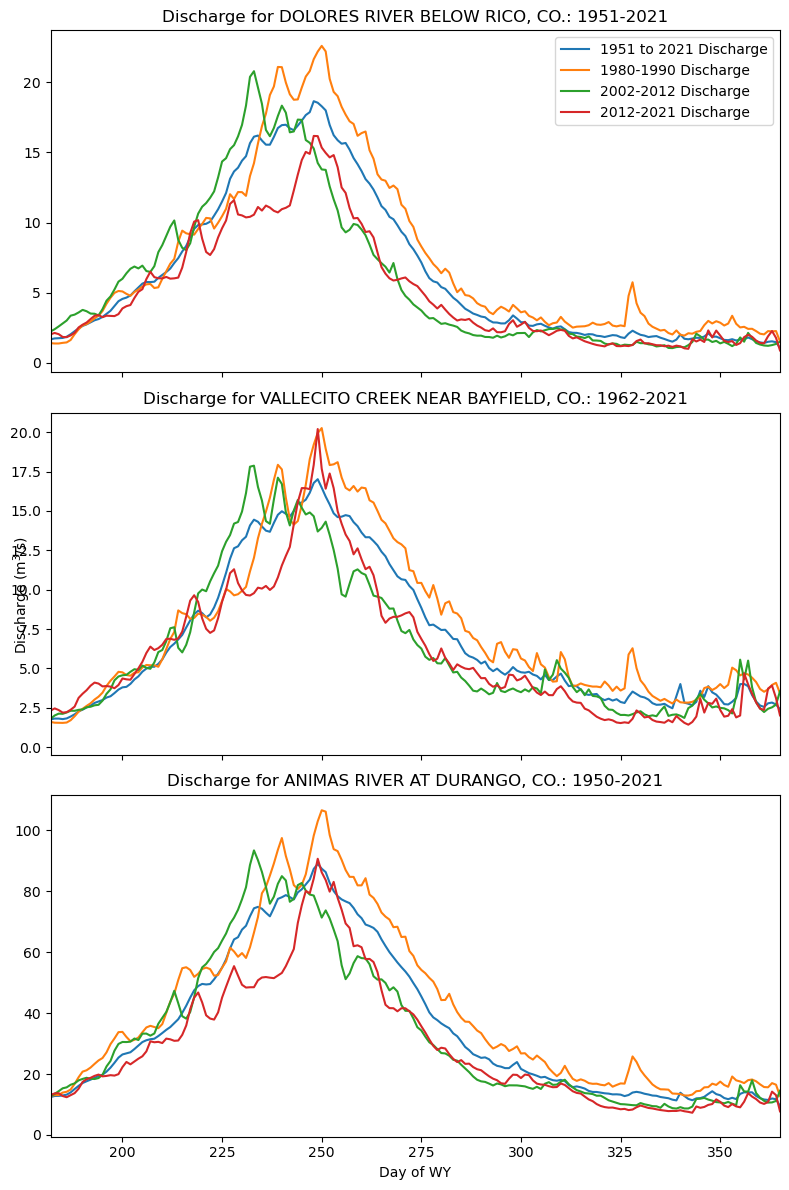

In [124]:
fig, axs = plt.subplots(nrows=len(southern_names[-3:]), figsize=(8,12), tight_layout=True, sharex=True)
for i,site in enumerate(southern_names[-3:]):
    ax=axs[i]
    min_year = streamflow_df[site].dropna().index.year.min()
    max_year = streamflow_df[site].dropna().index.year.max()
    (streamflow_df[[site,'dowy']].groupby('dowy').mean()*0.0283).plot(ax=ax, label=f'{min_year} to {max_year} Discharge',legend=False)
    (streamflow_df[[site,'dowy']].loc[dt.date(1980,10,1):dt.date(1990,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='1983-1987 Discharge',legend=False)
    (streamflow_df[[site,'dowy']].loc[dt.date(2000,10,1):dt.date(2011,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='2000-2004 Discharge',legend=False)
    # (streamflow_df[[site,'dowy']].loc[dt.date(2011,10,1):dt.date(2015,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='2012-2015 Discharge',legend=False)
    (streamflow_df[[site,'dowy']].loc[dt.date(2011,10,1):dt.date(2022,9,30)].groupby('dowy').mean()*0.0283).plot(ax=ax, label='2018-2022 Discharge',legend=False)
    ax.set_title
    if i == 0:
        ax.legend([f'{min_year} to {max_year} Discharge',
                    '1980-1990 Discharge',
                    '2002-2012 Discharge',
                    '2012-2021 Discharge'])
    ax.set_title(f'Discharge for {column_dict[site]}: {min_year}-{max_year}')
    # ax.set_ylabel('Discharge (cfs)')
    ax.set_xlabel('Day of WY')
    ax.set_xlim(182,365)
fig.text(0.02, 0.5, 'Discharge (m$^3$/s)', va='center', rotation='vertical')